In [89]:
%load_ext autoreload
%autoreload 2

# Head counter

In [2]:
import cv2
from skimage import io
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np


In [4]:
images = [io.imread(path) for path in Path('images').glob('*.jpg')]

In [5]:
gray_images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images]

reference_image = gray_images[0]
gray_images = gray_images[1:]


In [ ]:
# show images in notebook

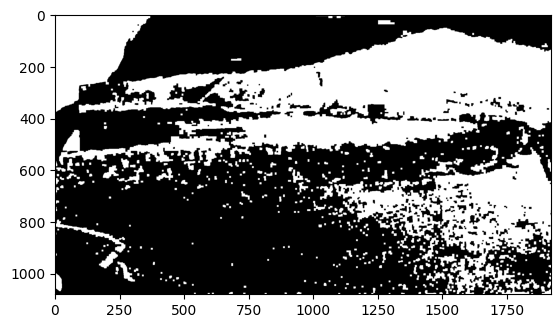

In [35]:
# Calculate the fixed part of the background
from lib.morphological import opening, closing


background_pixels = np.ones_like(reference_image)
for image in gray_images:
    diff = cv2.absdiff(reference_image, image)

    background_pixels &= diff < 65


background_pixels = opening(image=background_pixels, kernel=np.ones((7, 7)))
background_pixels = closing(image=background_pixels, kernel=np.ones((5, 5)))

plt.imshow(background_pixels, cmap='gray')

pass;


In [44]:
images_whitout_background = [image * (1-background_pixels) for image in gray_images]
reference_image = reference_image * (1-background_pixels)

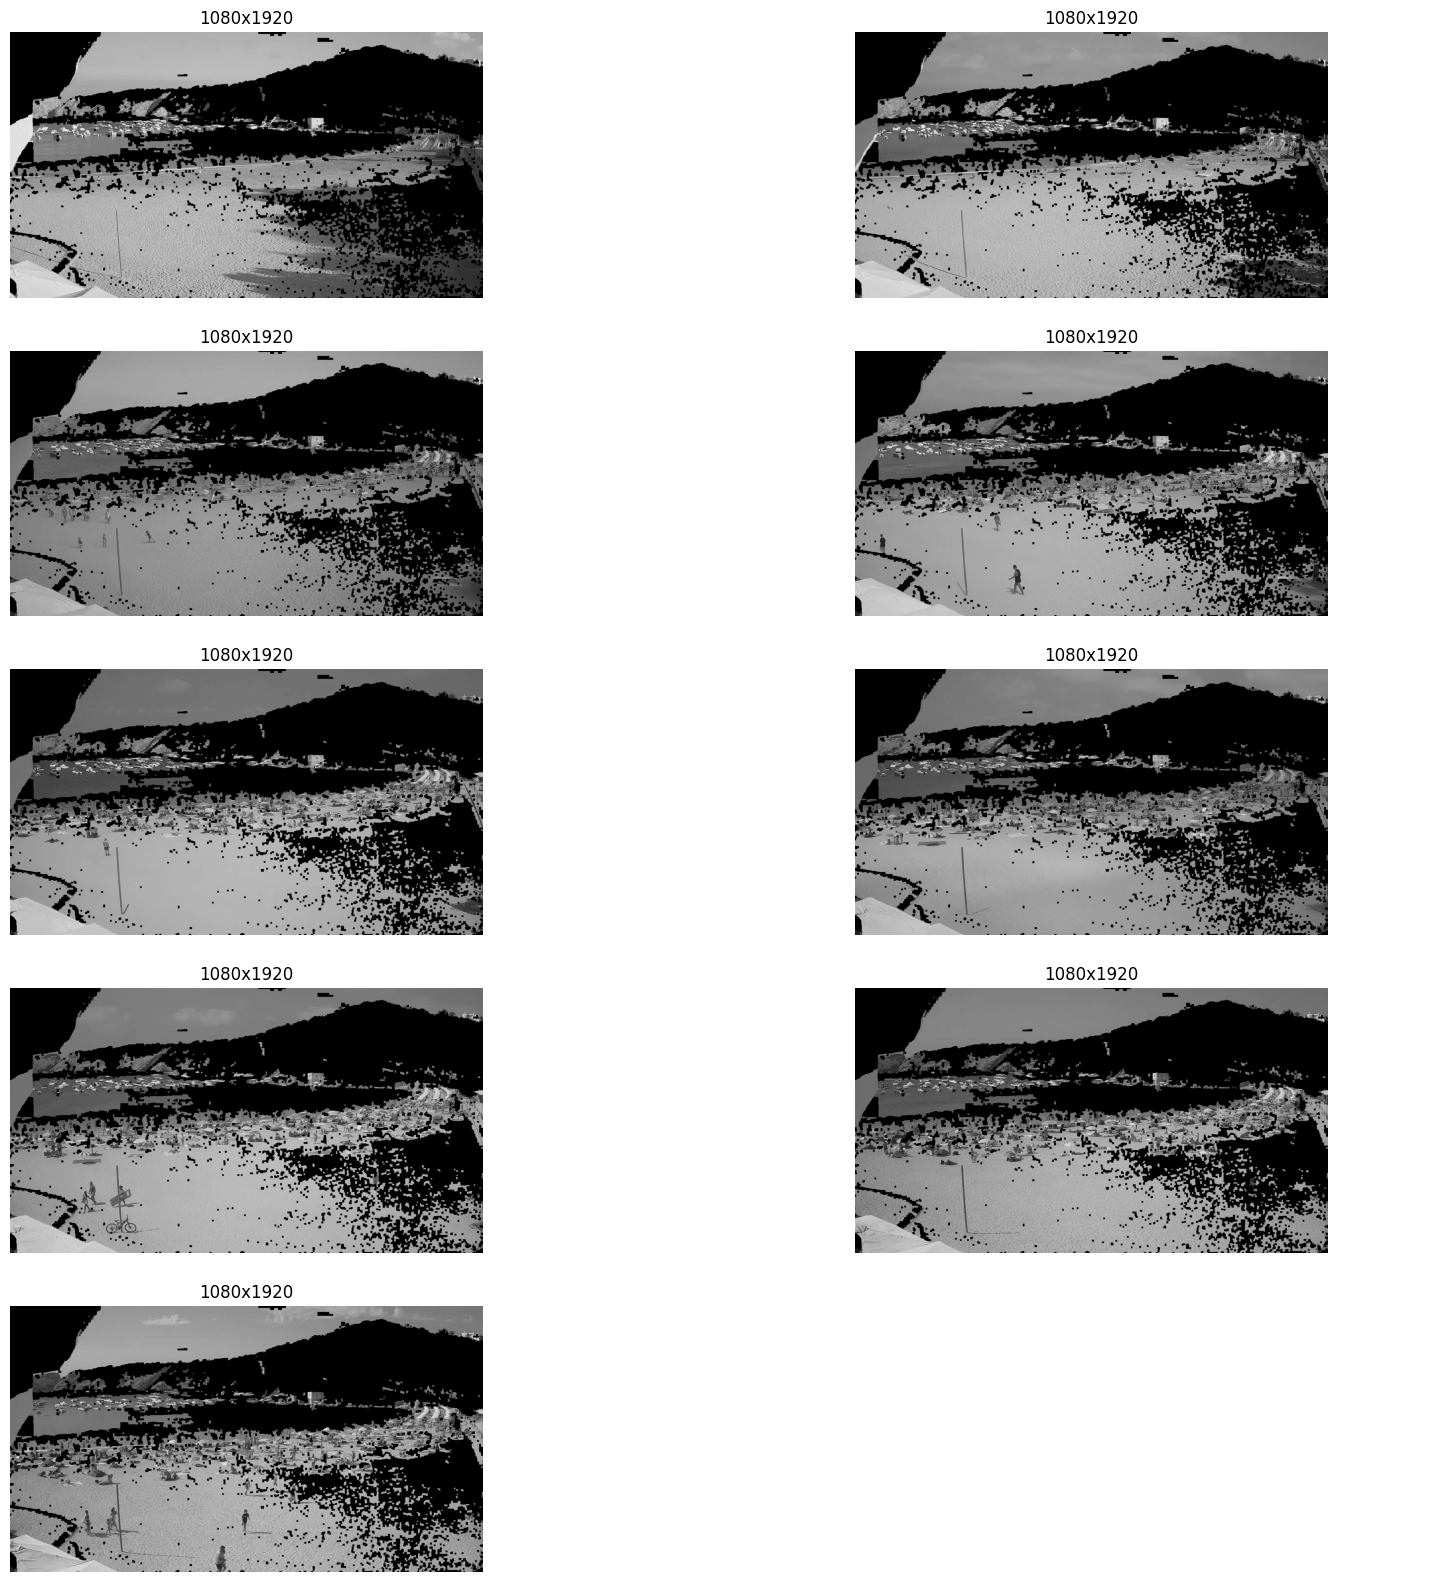

In [45]:
import math
n_cols = 2
fig, axes = plt.subplots(
    math.ceil(len(images_whitout_background)/n_cols), n_cols, figsize=(20, 20))

axes = axes.flatten()


for ax in axes:
    ax.axis('off')

for image, ax in zip(images_whitout_background, axes):
    ax.imshow(image, cmap='gray')
    ax.set_title(f'{image.shape[0]}x{image.shape[1]}')
    

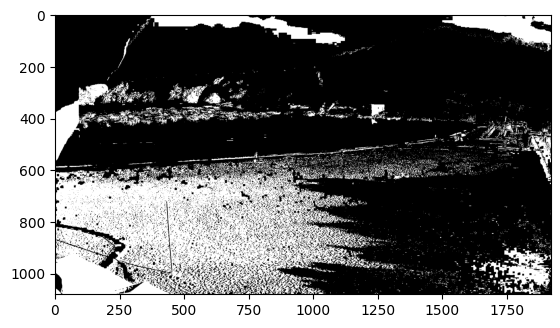

In [49]:
diff = cv2.absdiff(reference_image, images_whitout_background[0])

ret, thresh = cv2.threshold(diff, 40, 255, cv2.THRESH_BINARY)

plt.imshow(thresh, cmap='gray')